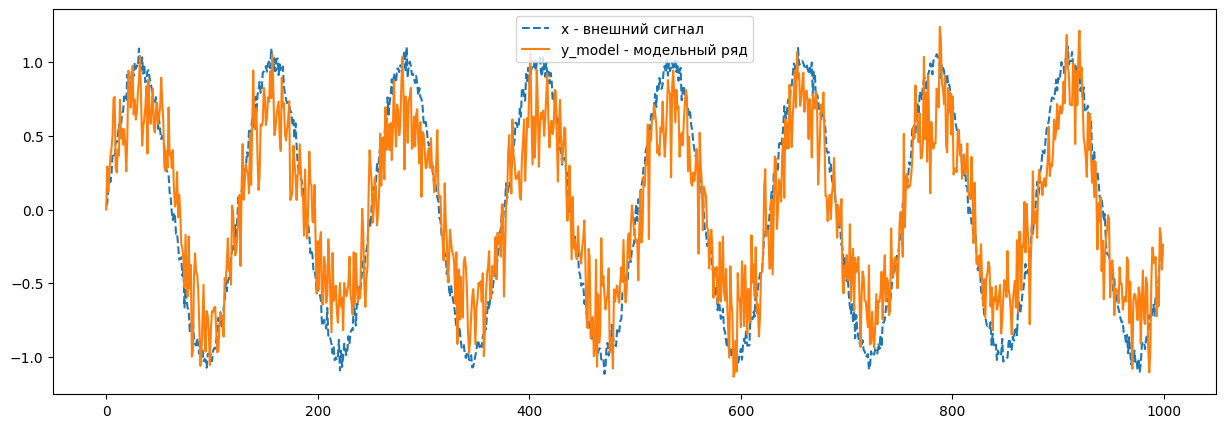

C:\Users\waclo\AppData\Local\Temp\ipykernel_18060\198969857.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)


Epoch 0, Train Loss: 0.25580930709838867, Validation Loss: 0.24092324078083038
Epoch 10, Train Loss: 0.07826900482177734, Validation Loss: 0.08054428547620773
Epoch 20, Train Loss: 0.054040804505348206, Validation Loss: 0.06267233192920685
Epoch 30, Train Loss: 0.04664578661322594, Validation Loss: 0.0520298071205616
Epoch 40, Train Loss: 0.043748676776885986, Validation Loss: 0.05189841613173485
Epoch 50, Train Loss: 0.04218908026814461, Validation Loss: 0.05153311416506767
Epoch 60, Train Loss: 0.041302964091300964, Validation Loss: 0.05116874724626541
Epoch 70, Train Loss: 0.04044593125581741, Validation Loss: 0.050254080444574356
Epoch 80, Train Loss: 0.03973628580570221, Validation Loss: 0.04965478181838989
Epoch 90, Train Loss: 0.03909924998879433, Validation Loss: 0.0493195615708828
Test Loss: 0.03705480322241783


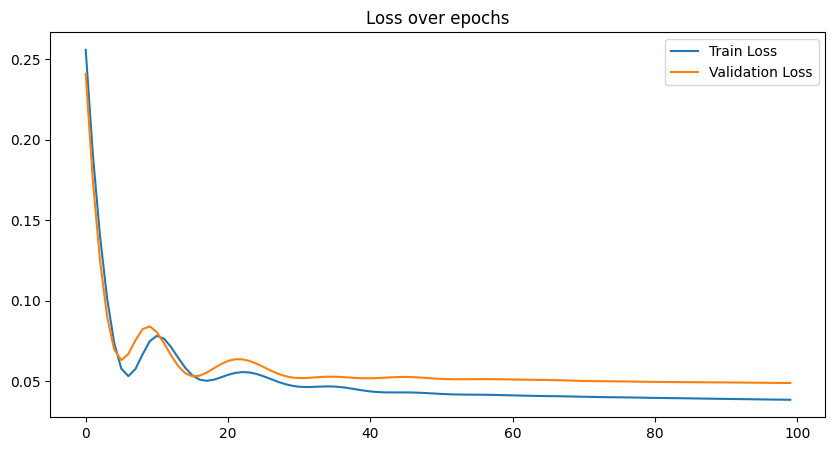

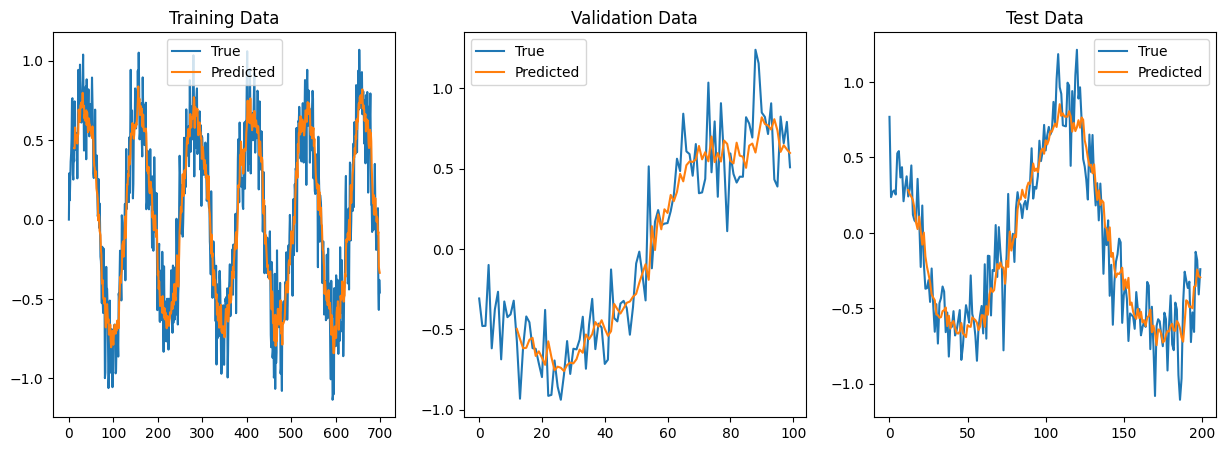

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)
torch.manual_seed(42)

# Генерация синтетических данных
n = 1000
x = np.sin(np.linspace(0, 50, n)) + np.random.normal(0, 0.05, n)
y_model = np.zeros(n)
y_true = np.zeros(n)

for t in range(1, n):
    y_model[t] = 0.3 * y_model[t-1] + 0.5 * x[t-1] + np.random.normal(0, 0.2)
    y_true[t] = y_model[t] + np.random.normal(0, 0.3)

# Визуализация данных
plt.figure(figsize=(15, 5))
plt.plot(x, label='x - внешний сигнал', linestyle='--')
plt.plot(y_model, label='y_model - модельный ряд')
plt.legend()
plt.show()

# Разделение данных на тренировочные, валидационные и тестовые
train_size = int(0.7 * n)
val_size = int(0.1 * n)
test_size = n - train_size - val_size

train_x = torch.tensor(x[:train_size], dtype=torch.float32).to(device)
train_y_model = torch.tensor(y_model[:train_size], dtype=torch.float32).to(device)
train_y_true = torch.tensor(y_true[:train_size], dtype=torch.float32).to(device)

val_x = torch.tensor(x[train_size:train_size+val_size], dtype=torch.float32).to(device)
val_y_model = torch.tensor(y_model[train_size:train_size+val_size], dtype=torch.float32).to(device)
val_y_true = torch.tensor(y_true[train_size:train_size+val_size], dtype=torch.float32).to(device)

test_x = torch.tensor(x[train_size+val_size:], dtype=torch.float32).to(device)
test_y_model = torch.tensor(y_model[train_size+val_size:], dtype=torch.float32).to(device)
test_y_true = torch.tensor(y_true[train_size+val_size:], dtype=torch.float32).to(device)

# Определение модели NARX
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.out(x)
        return x

# Параметры модели
window_size = 12
input_size = window_size + 1  # Включает x и window_size предыдущих значений y_model
hidden_size = 10
output_size = 1

# Создание модели, функции потерь и оптимизатора
model = NARX(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Функция для создания входных данных
def create_input_sequence(x, y_model, window_size):
    X = []
    Y = []
    for i in range(window_size, len(y_model)):
        X.append(np.hstack((x[i], y_model[i-window_size:i])))
        Y.append(y_model[i])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# Подготовка данных
train_X, train_Y = create_input_sequence(train_x.cpu().numpy(), train_y_model.cpu().numpy(), window_size)
val_X, val_Y = create_input_sequence(val_x.cpu().numpy(), val_y_model.cpu().numpy(), window_size)
test_X, test_Y = create_input_sequence(test_x.cpu().numpy(), test_y_model.cpu().numpy(), window_size)

train_X, train_Y = train_X.to(device), train_Y.to(device)
val_X, val_Y = val_X.to(device), val_Y.to(device)
test_X, test_Y = test_X.to(device), test_Y.to(device)

# Обучение модели
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_X)
    loss = criterion(outputs.squeeze(), train_Y)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(val_X)
        val_loss = criterion(val_outputs.squeeze(), val_Y)
        val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Оценка модели на тестовых данных
model.eval()
with torch.no_grad():
    test_outputs = model(test_X)
    test_loss = criterion(test_outputs.squeeze(), test_Y)
    print(f'Test Loss: {test_loss.item()}')

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Визуализация предсказаний
plt.figure(figsize=(15, 5))

# Обучающие данные и предсказания
plt.subplot(1, 3, 1)
train_predictions = model(train_X).detach().cpu().numpy()
plt.plot(train_y_model.cpu().numpy(), label='True')
plt.plot(np.arange(window_size, len(train_predictions)+window_size), train_predictions, label='Predicted')
plt.title('Training Data')
plt.legend()

# Валидационные данные и предсказания
plt.subplot(1, 3, 2)
val_predictions = model(val_X).detach().cpu().numpy()
plt.plot(val_y_model.cpu().numpy(), label='True')
plt.plot(np.arange(window_size, len(val_predictions)+window_size), val_predictions, label='Predicted')
plt.title('Validation Data')
plt.legend()

# Тестовые данные и предсказания
plt.subplot(1, 3, 3)
test_predictions = model(test_X).detach().cpu().numpy()
plt.plot(test_y_model.cpu().numpy(), label='True')
plt.plot(np.arange(window_size, len(test_predictions)+window_size), test_predictions, label='Predicted')
plt.title('Test Data')
plt.legend()

plt.show()
